In [38]:
"""
Here, we have the baselines as simple MLP.
First, we only map from recon loss to token count.
Second, we also add the heuristic features (lid and local density) as input to the MLP, to see if it can learn to use them to improve prediction.
Third, is the resnet, which uses the image features
"""

'\nHere, we have the baselines as simple MLP.\nFirst, we only map from recon loss to token count.\nSecond, we also add the heuristic features (lid and local density) as input to the MLP, to see if it can learn to use them to improve prediction.\nThird, is the resnet, which uses the image features\n'

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
import os
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
from data.utils.dataloaders import ReconstructionDataset_Heuristic


In [40]:
def prepare_reconstruction_dataset(reconst_loss_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json",
                                   LID_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/flextok_based/original_images/val/t_0.32/lid_0000_0329.json",
                                   best_LID_noise_level=[26,26,25,25,24,24,23,14,14],
                                   local_density_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/conditional/val",
                                   k_values = [1,2,4,8,16,32,64,128,256],
                                   lpips_variance_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/LPIPS_variance_reconstructions/val/reconst_"):
    
    """
    Read the reconstruction loss file, LID values for best noise levels, and local density information.
    Create and return a ReconstructionDataset_Heuristic instance.
    """
    if reconst_loss_file != None:
        # read reconstruction loss json file 
        with open(reconst_loss_file, 'r') as f:
            reconst_losses = json.load(f)
    else:
        reconst_losses = None

    if LID_file != None:
        # read LID values for best noise levels
        best_lids_per_k = {}
        for best_lid, k in zip(best_LID_noise_level, k_values):
            LID_JSON   = f"{LID_file}t_{best_lid}/lid_0000_3125.json"
            # Load LID values; we assume it's ordered so that index i corresponds to image i
            with open(LID_file, 'r') as f:
                lid_values = json.load(f)
            best_lids_per_k[k] = lid_values
    else:
        best_lids_per_k = None

    if local_density_file != None:
        # load densities
        density_dict = {}
        for k in k_values:
            with open(local_density_file, 'r') as f:
                current_densities = json.load(f)
            density_dict[k]=current_densities

        processed_density_dict = {}
        timestep_needed = [0,0,0,0,0,0,0,0,0]
        for idx, (key, value) in enumerate(density_dict.items()):
            processed_density_dict[key] = [sum(v[0][timestep_needed[idx]:]) for v in value]
    else:
        processed_density_dict = None

    if lpips_variance_file != None:
        # lpips variance information
        list_lpips_variances = {}
        k_values = [1,2,4,8,16,32,64,128,256]
        for k in k_values:
            with open(f"{lpips_variance_file}{k}.json") as f:
                k_variance = json.load(f)
                list_lpips_variances[k] = [v for inner in k_variance.values() for v in inner.values()]
    else:
        list_lpips_variances = None

    # create dataset
    ds = ReconstructionDataset_Heuristic(
        reconstruction_data=reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density_dict, # [l[0] for l in density]
        lid_information=best_lids_per_k,
        error_key=["LPIPS"],
        lpips_variance_information=list_lpips_variances
    )

    return ds

In [41]:
def find_bins(ds, k_values, num_bins=10, binning="quantile", normalize="prob"):
    """
    Find bin edges for reconstruction losses in the dataset.
    binning can be 'quantile' or 'uniform'.
    quantile: bins have equal number of samples
    uniform: bins have equal width
    """
    k_values = [int(k) for k in k_values]
    k_to_row = {k:i for i,k in enumerate(k_values)}

    losses = np.array([float(d["LPIPS"]) for d in ds], dtype=float)
    ks     = np.array([int(d["k_value"]) for d in ds], dtype=int)

    # bins on loss
    if binning == "quantile":
        q = np.linspace(0, 1, num_bins + 1)
        bin_edges = np.quantile(losses, q)
    elif binning == "uniform":
        bin_edges = np.linspace(losses.min(), losses.max(), num_bins + 1)
    else:
        raise ValueError("binning must be 'quantile' or 'uniform'")

    bin_edges[0]  -= 1e-9
    bin_edges[-1] += 1e-9

    # matrix [num_k, num_bins]
    token_prob_across_recon_loss = np.zeros((len(k_values), num_bins), dtype=float)
    for loss, k in zip(losses, ks):
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))
        token_prob_across_recon_loss[k_to_row[k], b] += 1

    if normalize == "prob":
        col_sums = token_prob_across_recon_loss.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1.0
        token_prob_across_recon_loss = token_prob_across_recon_loss / col_sums

    return bin_edges, token_prob_across_recon_loss

In [42]:
def plot_k_vs_loss_heatmap(bin_edges, M, k_values, num_bins=10, normalize="prob"):
    """
    Heatmap of token distribution across LPIPS bins.
      x-axis: LPIPS bins
      y-axis: k values
      color : count or probability

    normalize:
      - "count": show raw counts
      - "prob":  show per-bin probabilities (each column sums to 1)
    """
    

    # x labels
    x_labels = [f"[{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f}]" for i in range(num_bins)]

    plt.figure(figsize=(12, 5))
    plt.imshow(M, aspect="auto", origin="lower")
    plt.colorbar(label=("Probability" if normalize=="prob" else "Count"))

    plt.xticks(range(num_bins), x_labels, rotation=45, ha="right")
    plt.yticks(range(len(k_values)), [str(k) for k in k_values])

    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.ylabel("Token count (k)")
    plt.title("P(k | loss bin)" if normalize=="prob" else "Counts of k per loss bin")
    plt.tight_layout()
    plt.show()


In [43]:
ds_val = prepare_reconstruction_dataset(reconst_loss_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json", 
                                        local_density_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/original_val/unconditional/combined.json",
                                        LID_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/flextok_based/original_images/val/t_0.32/lid_0000_0329.json")

In [44]:
mlp_lid_local_density = [1.1616, 1.2608, 1.2811, 1.5484, 1.7712, 1.6508, 1.1374, 0.7956, 0.6995, 0.6604]
mlp_only_recon_loss = [1.0689, 1.2352, 1.3871, 1.7092, 1.8323, 1.6453, 1.1233, 0.7849, 0.6625, 0.6023]
resnet_fine_tuned = [0.9745, 0.7937, 0.7610, 0.9477, 1.2397, 1.3551, 1.0658, 0.7987, 0.7678, 0.6321]

In [45]:
k_values = [1,2,4,8,16,32,64,128,256]

bin_edges_val, token_prob_across_recon_loss_val = find_bins(ds_val, k_values, num_bins=10, binning="uniform", normalize="prob")


In [46]:
# creating a list of [bin_start, bin_end] for each bin for easier interpretation/printing later
bin_begin_end = []
for b in range(len(bin_edges_val)-1):
    bin_begin_end.append([bin_edges_val[b], bin_edges_val[b+1]])
print(bin_edges_val)
print(bin_begin_end, len(bin_begin_end))

[0.02079272 0.12662399 0.23245525 0.33828652 0.44411778 0.54994905
 0.65578032 0.76161158 0.86744285 0.97327411 1.07910538]
[[0.020792721702026368, 0.1266239881515503], [0.1266239881515503, 0.23245525360107422], [0.23245525360107422, 0.33828651905059814], [0.33828651905059814, 0.44411778450012207], [0.44411778450012207, 0.549949049949646], [0.549949049949646, 0.6557803153991699], [0.6557803153991699, 0.7616115808486938], [0.7616115808486938, 0.8674428462982178], [0.8674428462982178, 0.9732741117477417], [0.9732741117477417, 1.0791053781972657]] 10


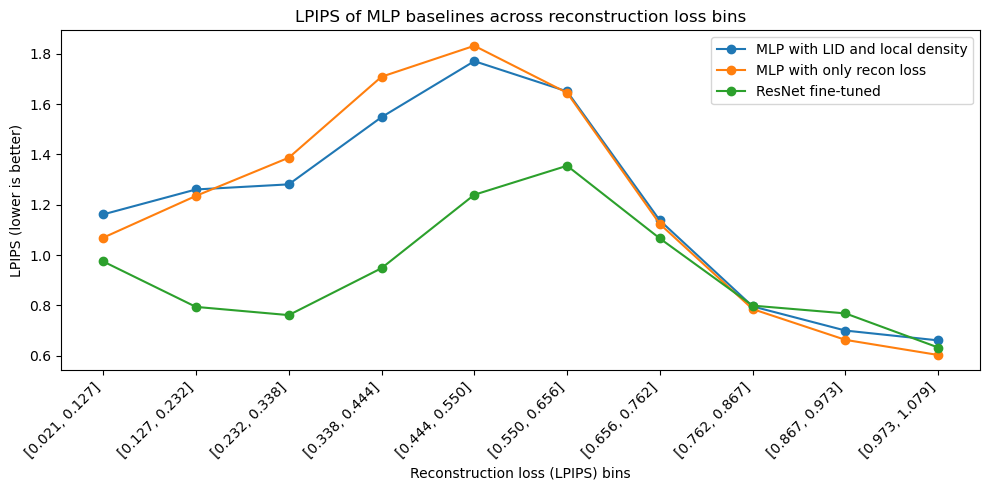

In [47]:
x = bin_edges_val[:-1]

plt.figure(figsize=(10,5))
plt.plot(x, mlp_lid_local_density, marker='o', label="MLP with LID and local density")
plt.plot(x, mlp_only_recon_loss, marker='o', label="MLP with only recon loss")
plt.plot(x, resnet_fine_tuned, marker='o', label="ResNet fine-tuned")
plt.xlabel("Reconstruction loss (LPIPS) bins")

x_labels = [f"[{bin_edges_val[i]:.3f}, {bin_edges_val[i+1]:.3f}]" 
            for i in range(len(bin_edges_val)-1)]

plt.xticks(x, x_labels, rotation=45, ha="right")

plt.ylabel("LPIPS (lower is better)")
plt.title("LPIPS of MLP baselines across reconstruction loss bins")
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
##### based on token count
mlp_lid_local_density = [1.2201, 1.3922, 1.7291, 1.8194, 1.8405, 1.8563, 1.7766, 1.3531, 0.9551]
mlp_lid_local_density_normalized = [1.1405, 1.3708, 1.6834, 1.7602, 1.8112, 1.7553, 1.6759, 1.4275, 0.9164]

mlp_density_only = [1.1380, 1.4377, 1.7157, 1.8517, 1.9098, 1.8884, 1.7716, 1.5509, 1.1429]
mlp_lid_only = [1.0984, 1.4104, 1.6953, 1.7922, 1.7910, 1.7772, 1.6384, 1.4411, 0.8745]

mlp_only_recon_loss = [1.1563, 1.4726, 1.7817, 1.8670, 1.8652, 1.8500, 1.7380, 1.5667, 1.1590]
mlp_only_recon_loss_normalized = [1.1706, 1.4330, 1.7757, 1.8584, 1.9033, 1.8472, 1.7677, 1.5332, 1.1674]

resnet_fine_tuned = [0.8660, 1.1929, 1.5067, 1.4893, 1.3956, 1.3573, 1.0868, 0.8675, 0.3895]

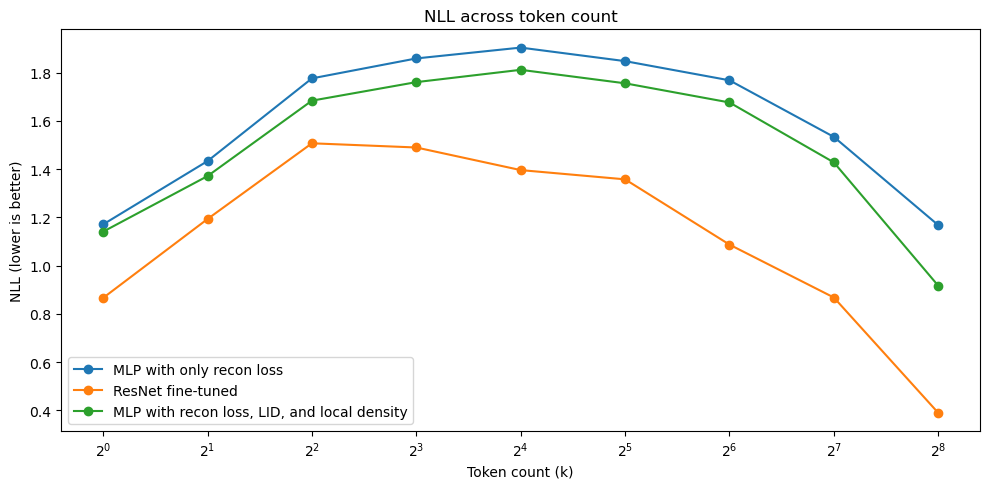

In [76]:


plt.figure(figsize=(10,5))
#plt.plot(k_values, mlp_lid_local_density, marker='o', label="MLP with recon loss, LID, and local density")

#plt.plot(k_values, mlp_only_recon_loss, marker='o', label="MLP with only recon loss")
plt.plot(k_values, mlp_only_recon_loss_normalized, marker='o', label="MLP with only recon loss")
plt.plot(k_values, resnet_fine_tuned, marker='o', label="ResNet fine-tuned")

plt.plot(k_values, mlp_lid_local_density_normalized, marker='o', label="MLP with recon loss, LID, and local density")
#plt.plot(k_values, mlp_density_only, marker='o', label="MLP with recon loss and local density only")
#plt.plot(k_values, mlp_lid_only, marker='o', label="MLP with recon loss and LID only")
# do log scale
plt.xscale("log", base=2)
plt.xlabel("Token count (k)")
plt.ylabel("NLL (lower is better)")
plt.title("NLL across token count")
plt.legend()
plt.tight_layout()
plt.savefig("/BS/data_mani_compress/work/thesis/thesis/output/predicting_token_count/predicting_token_count_LPIPS.pdf")
plt.show()
